In [1]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from task_5_core.lvq import LVQ 

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = list(map(lambda arr: arr.reshape(784).astype('float64'), train_images))
test_images = list(map(lambda arr: arr.reshape(784).astype('float64'), test_images))

train_data, test_data = (train_images, train_labels), (test_images, test_labels)

In [3]:
def train_and_test(train_data, test_data, pattern_split=0.01, epochs=1, alpha=0.01, learning_rule='classic'):
    model = LVQ()

    patterns_count = int(len(train_data[0]) * pattern_split)
    init_data = (train_data[0][:patterns_count], train_data[1][:patterns_count])
    
    fit_data = (train_data[0][patterns_count:], train_data[1][patterns_count:])
    model.train(init_data, fit_data, learning_rule, alpha, epochs)

    features, labels = test_data 
    predictions = model.predict(features)

    metrics = (
        accuracy_score(labels, predictions),
        f1_score(labels, predictions, average='macro'),
        recall_score(labels, predictions, average='macro', zero_division=0),
        precision_score(labels, predictions, average='macro', zero_division=0)
    )
    return metrics

Three learning rules are compared:
* Classic - if BMU (winner) has the same label as entry it is pulled towards entry, otherwise it's pulled from the entry
* Attracting - No pulling from the entry, only towards right guesses
* Two-step - if BMU (winner) has the same label as entry it is pulled towards entry, however if it hasn't not only it's pulled from the entry, but the closest right vector is taken and pulled towards the entry

Patterns are selected randomly, so their distribution can be unbalanced and (with very small split) not complete

In [4]:
pattern_split_options = [0.0001, 0.0004, 0.001, 0.0025]
epochs_options = [1, 2, 5]
alpha_options = [0.001, 0.01, 0.05]
learning_rules = ['classic', 'two_step', 'attracting']
options = set(itertools.product(pattern_split_options, epochs_options, alpha_options, learning_rules))

def pattern_split_metrics():
    return {pattern_split: {} for pattern_split in pattern_split_options}

def epochs_metrics(): 
    return {epochs: pattern_split_metrics() for epochs in epochs_options}

def alpha_metrics():
    return {alpha: epochs_metrics() for alpha in alpha_options}

history = {rule: alpha_metrics() for rule in learning_rules}

for pattern_split, epochs, alpha, learning_rule in options:
    metrics = train_and_test(train_data, test_data, pattern_split=pattern_split, epochs=epochs, alpha=alpha, learning_rule=learning_rule)
    history[learning_rule][alpha][epochs][pattern_split] = metrics

d:\conda\envs\anns3.9\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
d:\ХНУРЕ\шнмз\python_neural_nets\tasks\task_5_core\lvq.py:10: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.sum(np.square(first - second), axis=1))
d:\ХНУРЕ\шнмз\python_neural_nets\tasks\task_5_core\lvq.py:46: RuntimeWarning: overflow encountered in subtract
  bmu_w -= error * alpha
d:\ХНУРЕ\шнмз\python_neural_nets\tasks\task_5_core\lvq.py:44: RuntimeWarning: invalid value encountered in add
  bmu_w += error * alpha
d:\conda\envs\anns3.9\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
d:\conda\envs\anns3.9\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
d:\conda\envs\anns3.9\lib\site-

In [5]:
rows = {'rule': [], 'alpha': [], 'epoch': [], 'pattern': [], 'accuracy': [], 'f1': [], 'recall': [], 'precision': []}
for rule in learning_rules:
    for alpha in alpha_options:
        for epoch in epochs_options:
            for pattern in pattern_split_options:
                m = history[rule][alpha][epoch][pattern]
                print(f'For rule: {rule}, alpha: {alpha}, epoch: {epoch}, pattern: {pattern}\n'
                      f'Accuracy = {m[0]}, F1 = {m[1]}, Recall = {m[2]}, Precision = {m[3]}')
                values = {'rule': rule, 'alpha': alpha, 'epoch': epoch, 'pattern': pattern,
                          'accuracy': m[0], 'f1': m[1], 'recall': m[2], 'precision': m[3]}
                for key, value in values.items():
                    rows[key].append(value)
result_df = pd.DataFrame.from_dict(rows).sort_values(['accuracy'], ascending=False)
result_df.head(len(result_df))

For rule: classic, alpha: 0.001, epoch: 1, pattern: 0.0001
Accuracy = 0.0892, F1 = 0.01637899375688579, Recall = 0.1, Precision = 0.00892
For rule: classic, alpha: 0.001, epoch: 1, pattern: 0.0004
Accuracy = 0.0892, F1 = 0.01637899375688579, Recall = 0.1, Precision = 0.00892
For rule: classic, alpha: 0.001, epoch: 1, pattern: 0.001
Accuracy = 0.0892, F1 = 0.01637899375688579, Recall = 0.1, Precision = 0.00892
For rule: classic, alpha: 0.001, epoch: 1, pattern: 0.0025
Accuracy = 0.0892, F1 = 0.01637899375688579, Recall = 0.1, Precision = 0.00892
For rule: classic, alpha: 0.001, epoch: 2, pattern: 0.0001
Accuracy = 0.0892, F1 = 0.01637899375688579, Recall = 0.1, Precision = 0.00892
For rule: classic, alpha: 0.001, epoch: 2, pattern: 0.0004
Accuracy = 0.0892, F1 = 0.01637899375688579, Recall = 0.1, Precision = 0.00892
For rule: classic, alpha: 0.001, epoch: 2, pattern: 0.001
Accuracy = 0.0892, F1 = 0.01637899375688579, Recall = 0.1, Precision = 0.00892
For rule: classic, alpha: 0.001, epo

,rule,alpha,epoch,pattern,accuracy,f1,recall,precision
55,two_step,0.010,2,0.0025,0.9096,0.908341,0.908487,0.909891
58,two_step,0.010,5,0.0010,0.8960,0.894598,0.894473,0.896299
78,attracting,0.001,2,0.0010,0.8847,0.883952,0.882985,0.890091
66,two_step,0.050,2,0.0010,0.8583,0.856137,0.855473,0.864131
53,two_step,0.010,2,0.0004,0.8107,0.809378,0.808193,0.829650
...,...,...,...,...,...,...,...,...
32,classic,0.050,5,0.0001,0.0892,0.016379,0.100000,0.008920
31,classic,0.050,2,0.0025,0.0892,0.016379,0.100000,0.008920
30,classic,0.050,2,0.0010,0.0892,0.016379,0.100000,0.008920
29,classic,0.050,2,0.0004,0.0892,0.016379,0.100000,0.008920


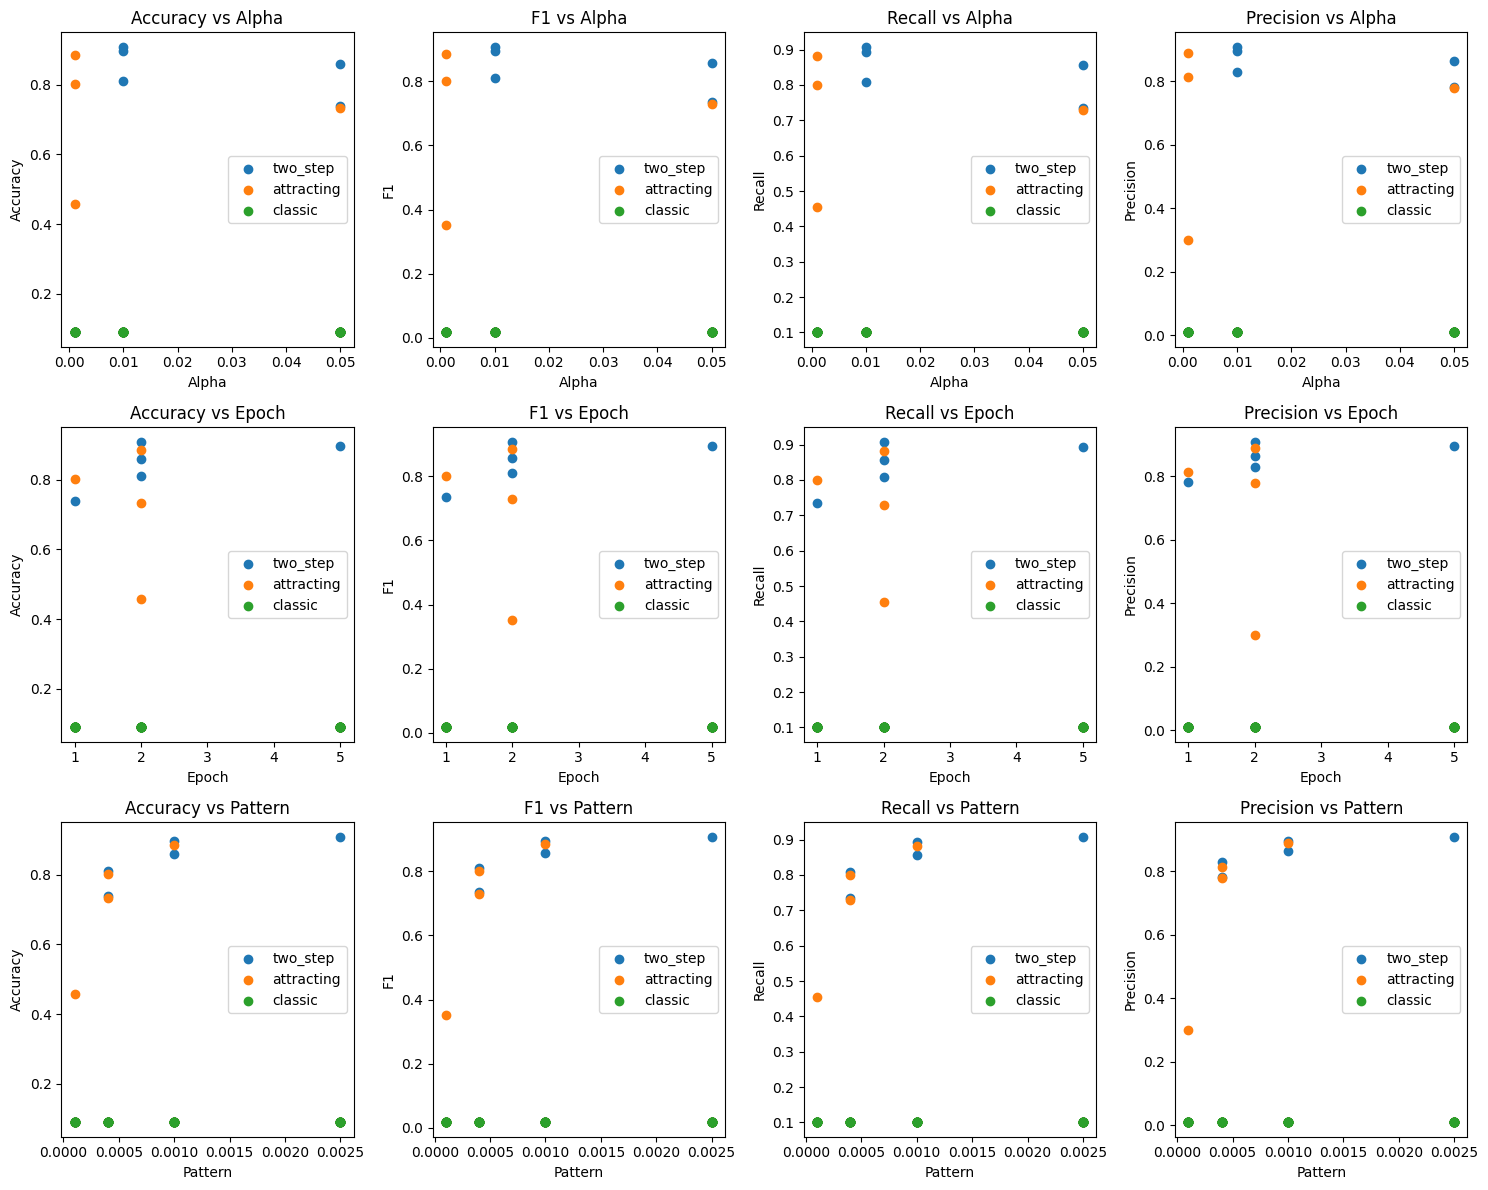

In [6]:
hyperparameters_to_visualize = ['alpha', 'epoch', 'pattern']
metrics_to_visualize = ['accuracy', 'f1', 'recall', 'precision']

fig, axes = plt.subplots(nrows=len(hyperparameters_to_visualize), ncols=len(metrics_to_visualize), figsize=(15, 12))

for i, hyperparam in enumerate(hyperparameters_to_visualize):
    for j, metric in enumerate(metrics_to_visualize):
        ax = axes[i, j]
        ax.set_title(f'{metric.capitalize()} vs {hyperparam.capitalize()}')
        ax.set_xlabel(hyperparam.capitalize())
        ax.set_ylabel(metric.capitalize())

        for rule in result_df['rule'].unique():
            rule_data = result_df[result_df['rule'] == rule]
            ax.scatter(rule_data[hyperparam], rule_data[metric], label=rule)

        ax.legend()

plt.tight_layout()
plt.show()

rule: classic, alpha: 0.001
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}


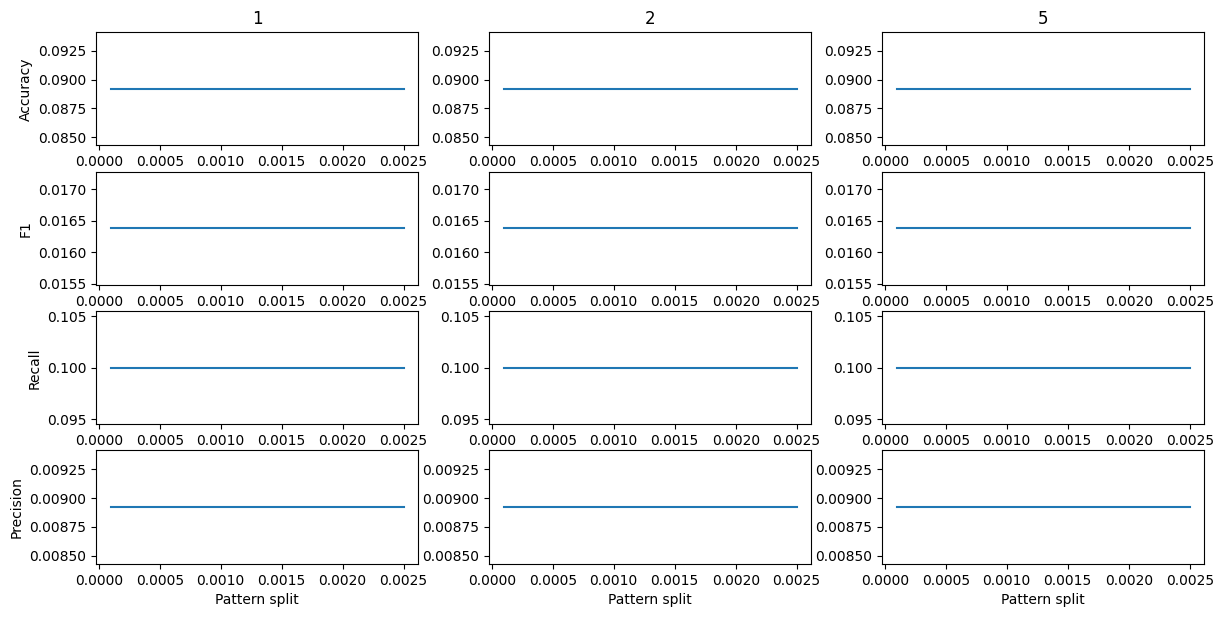

rule: classic, alpha: 0.01
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}


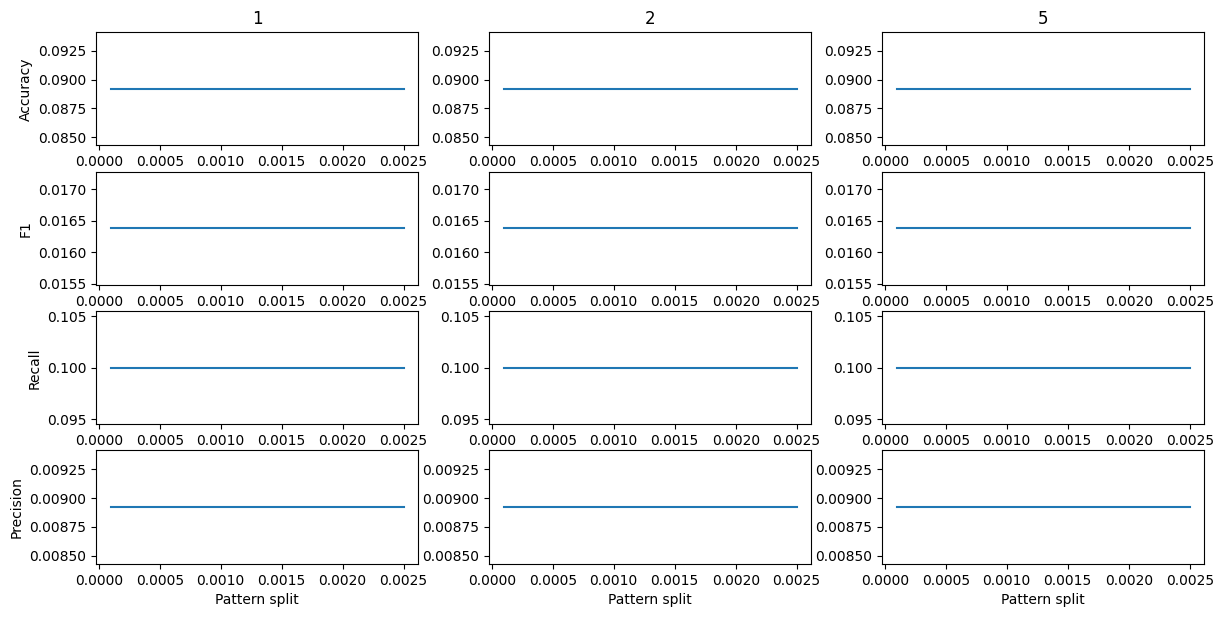

rule: classic, alpha: 0.05
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}


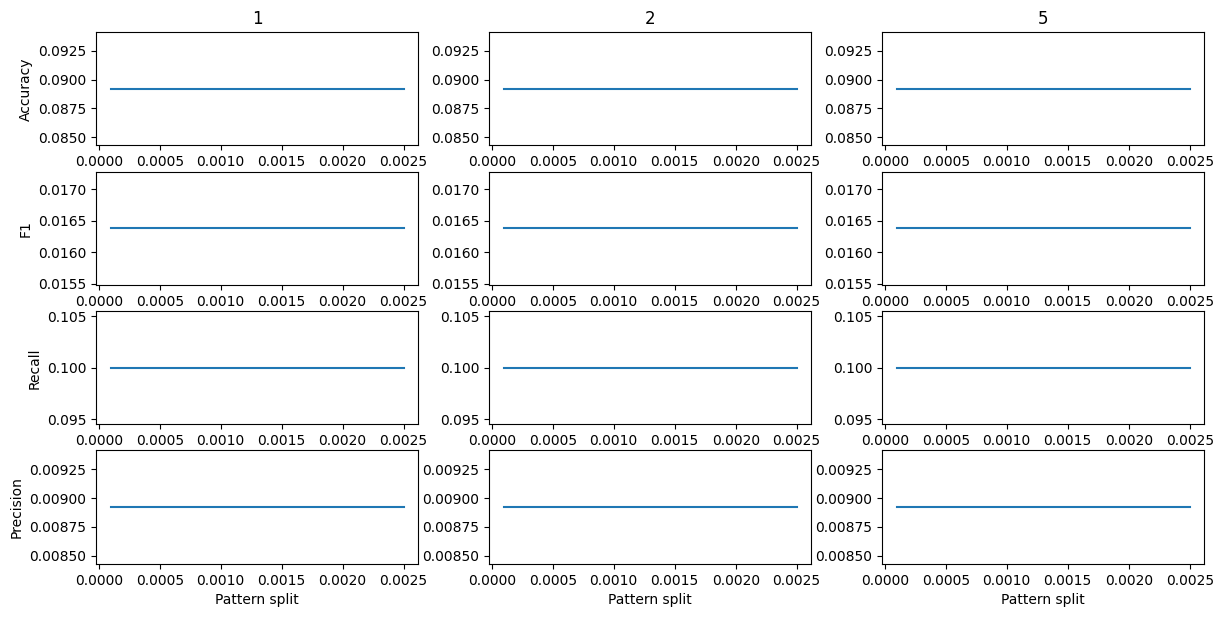

rule: two_step, alpha: 0.001
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}


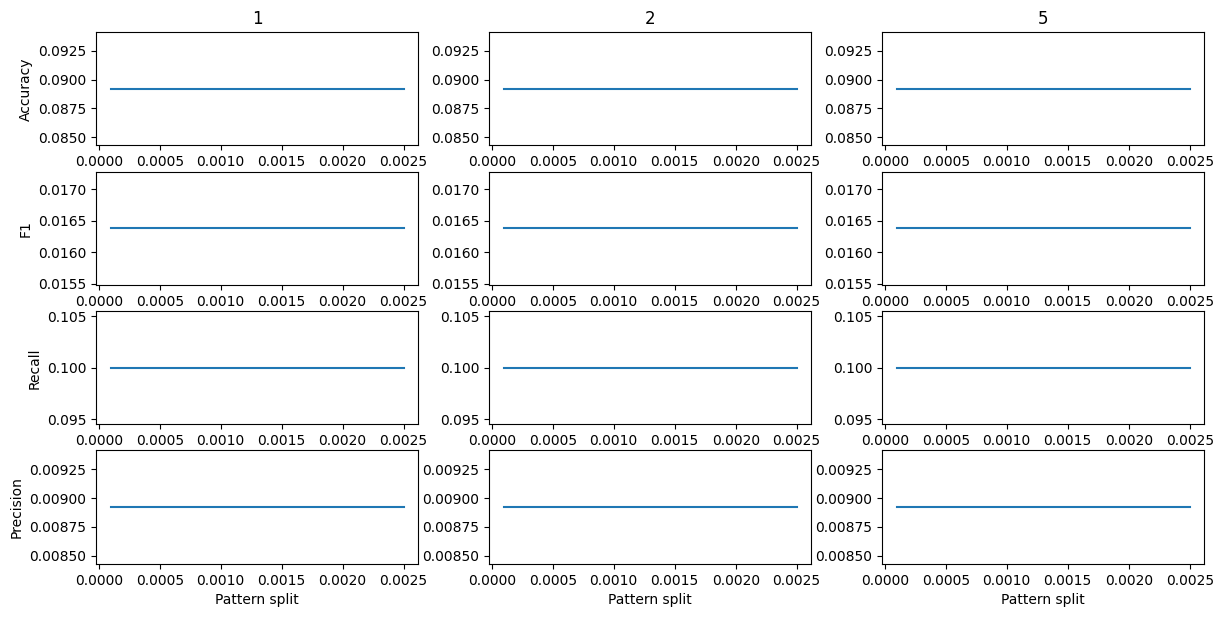

rule: two_step, alpha: 0.01
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.8107, 0.8093778156962536, 0.8081929981089617, 0.829650050194498), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.9096, 0.9083413819147301, 0.9084865450091678, 0.9098911170600781)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.896, 0.894597537525911, 0.8944727476215732, 0.8962988836753881), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}


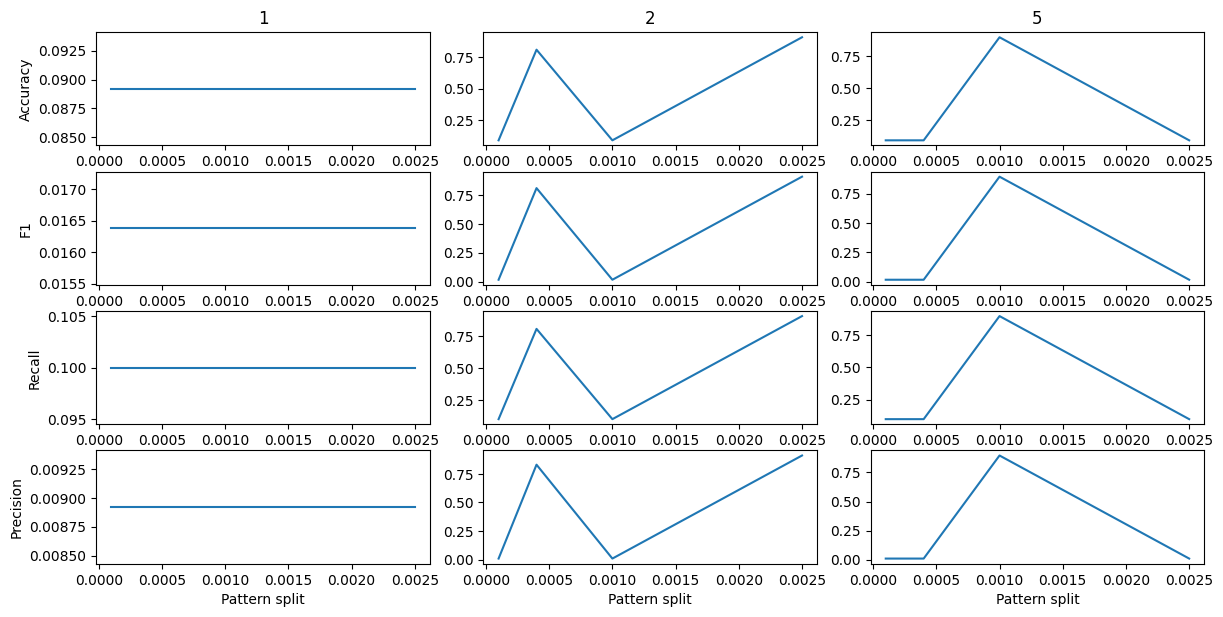

rule: two_step, alpha: 0.05
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.7402, 0.7366220893689863, 0.7353773016153565, 0.7839304230018366), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.8583, 0.8561365411369491, 0.8554733948296247, 0.8641310061806668), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}


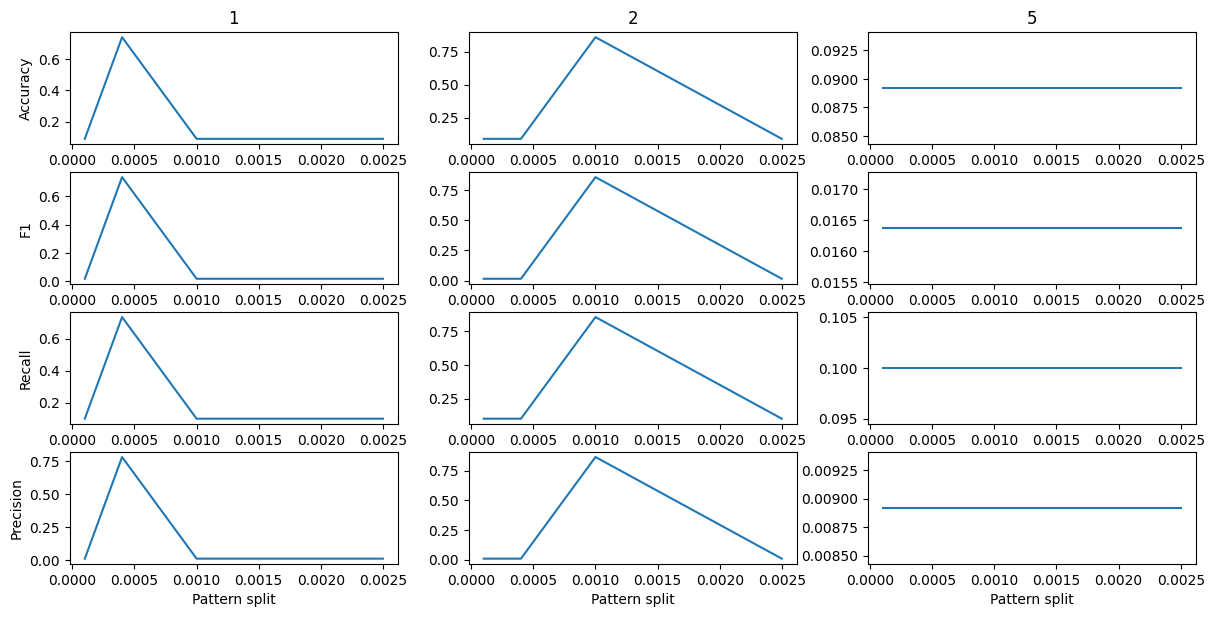

rule: attracting, alpha: 0.001
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.8035, 0.8010504160225315, 0.8005147605083481, 0.8130823288689042), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.4584, 0.3526612029241615, 0.45368071075572464, 0.3014926841587523), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.8847, 0.8839519380240827, 0.8829854933632454, 0.8900913002670918), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}


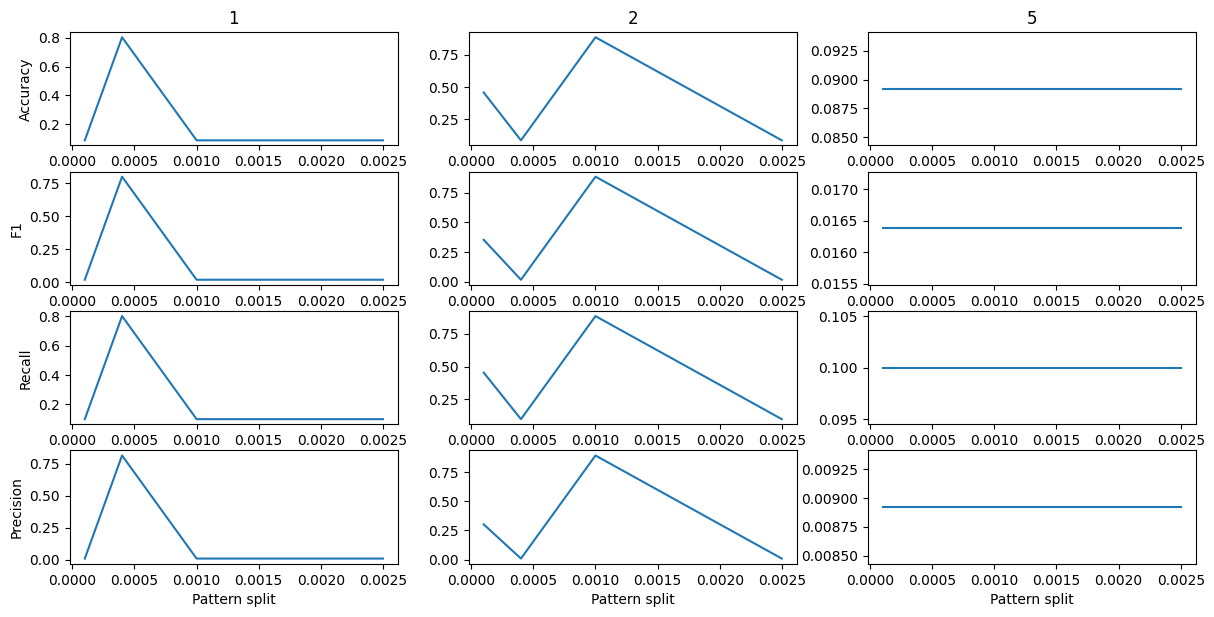

rule: attracting, alpha: 0.01
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}


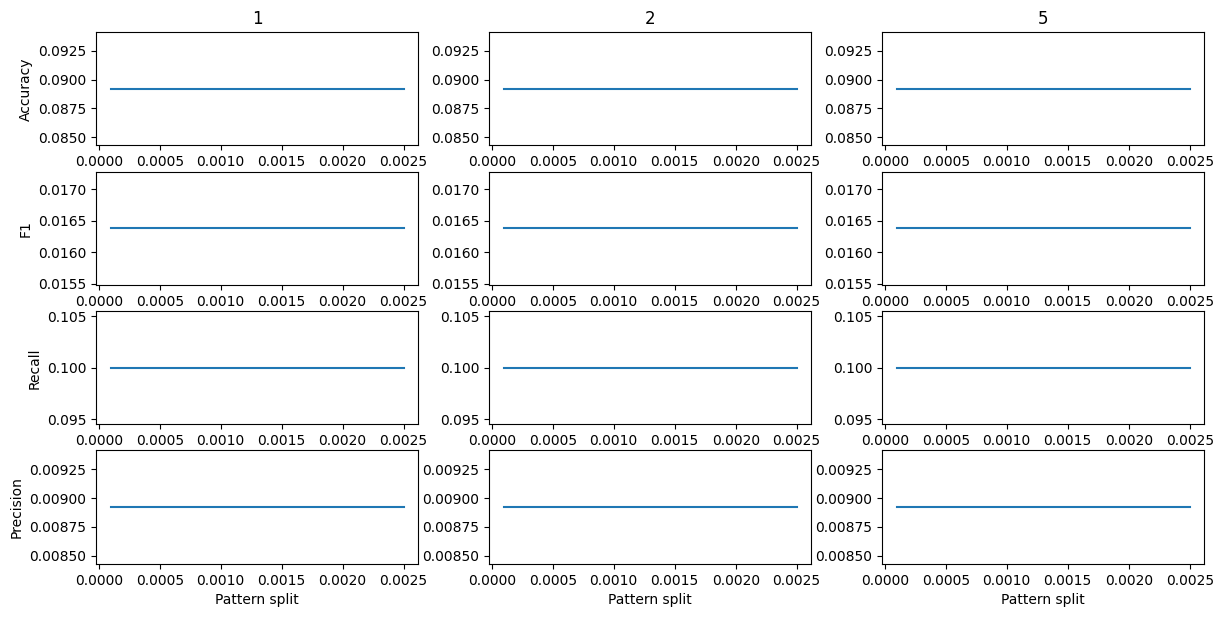

rule: attracting, alpha: 0.05
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.7347, 0.7302308733299687, 0.7300920353528714, 0.7806896312306847), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0004: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}


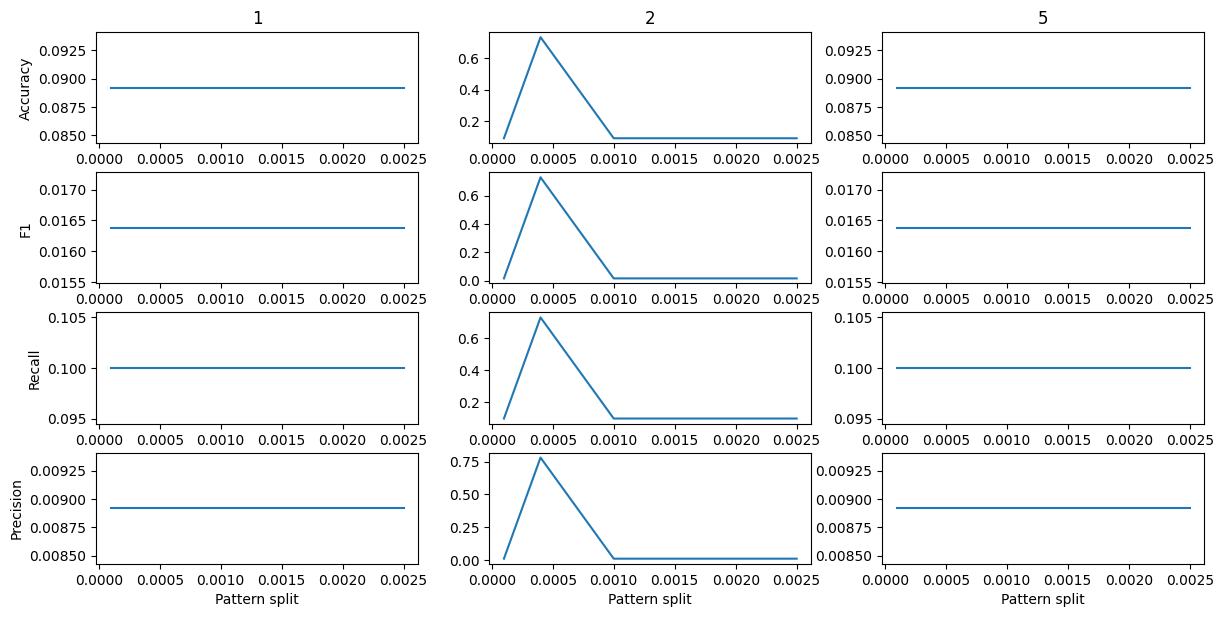

In [7]:
def visualize_dict_metrics(history):
    metric_names = ['Accuracy', 'F1', 'Recall', 'Precision']
    
    for rule, alphas_dict in history.items():
        for alpha, epochs_dict in alphas_dict.items():
            print(f'rule: {rule}, alpha: {alpha}')
            fig = plt.figure(figsize=(12, 6))

            for epochs, metrics in epochs_dict.items(): 
                offset = list(epochs_dict.keys()).index(epochs)
                print(metrics)

                plt.subplot(4, 3, 1 + offset)
                plt.plot(metrics.keys(), [metric[0] for metric in metrics.values()], label=f'{alpha} - {metric_names[0]}')
                plt.title(f'{epochs}')
                if offset == 0:
                    plt.ylabel(metric_names[0])

                plt.subplot(4, 3, 4 + offset)
                plt.plot(metrics.keys(), [metric[1] for metric in metrics.values()], label=f'{alpha} - {metric_names[1]}')
                if offset == 0:
                    plt.ylabel(metric_names[1])

                plt.subplot(4, 3, 7 + offset)
                plt.plot(metrics.keys(), [metric[2] for metric in metrics.values()], label=f'{alpha} - {metric_names[2]}')
                if offset == 0:
                    plt.ylabel(metric_names[2])

                plt.subplot(4, 3, 10 + offset)
                plt.plot(metrics.keys(), [metric[3] for metric in metrics.values()], label=f'{alpha} - {metric_names[3]}')
                if offset == 0:
                    plt.ylabel(metric_names[3])
                plt.xlabel('Pattern split')

            fig.tight_layout(pad=0.1)
            plt.show()


visualize_dict_metrics(history)

From the results we can make next conclusions:
* Classic update does not converge (at least with current pattern split)
* On the other hand Attracting and Two-step functions perform good, Two-step performs better
* All 3 parameters (epochs, learning rate and pattern split) are strongly connected: smaller splits need higher learning rate and learning rate being static causes higher errors. As the result we don't have much outliers and bad reaults in mid-range parameters, but they're not the best results either
* Results with higher split are generally better, but more computationaly intensive and need proper tuning